## 모델 학습을 위한 데이터셋(dataset) 준비하기

In [1]:
# 경고 메시지 출력 방지
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 필요한 라이브러리 불러오기
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# tensorflow_datasets 패키지 불러오기
import tensorflow_datasets as tfds

In [4]:
# 클라우드 환경에 폴더 생성
#!mkdir -p ~/aiffel/flowers/FlowersImages

In [5]:
# 가져온 데이터 Train, Validation, Test dateset으로 split 해주기
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir='~/aiffel/flowers/',
    download=True,
    with_info=True,
    as_supervised=True
)

In [6]:
# 각각의 데이터셋 확인
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


## 데이터 시각화를 통해 확인하고, 모델에 입력할 수 있는 형태로 전처리하기

In [7]:
# 데이터를 확인하기 위해 'matplotlib' 라이브러리를 가져오기
import matplotlib.pyplot as plt
# 쥬피터 노트북을 실행한 브라우저에서 바로 그림을 볼수 있게 즉, 브라우저 내부(inline) 에 바로 그려지도록 해주는 코드
%matplotlib inline
# 한글 폰트 사용시 글자를 선명하게 하는 명령어
%config InlineBackend.figure_format = 'retina'

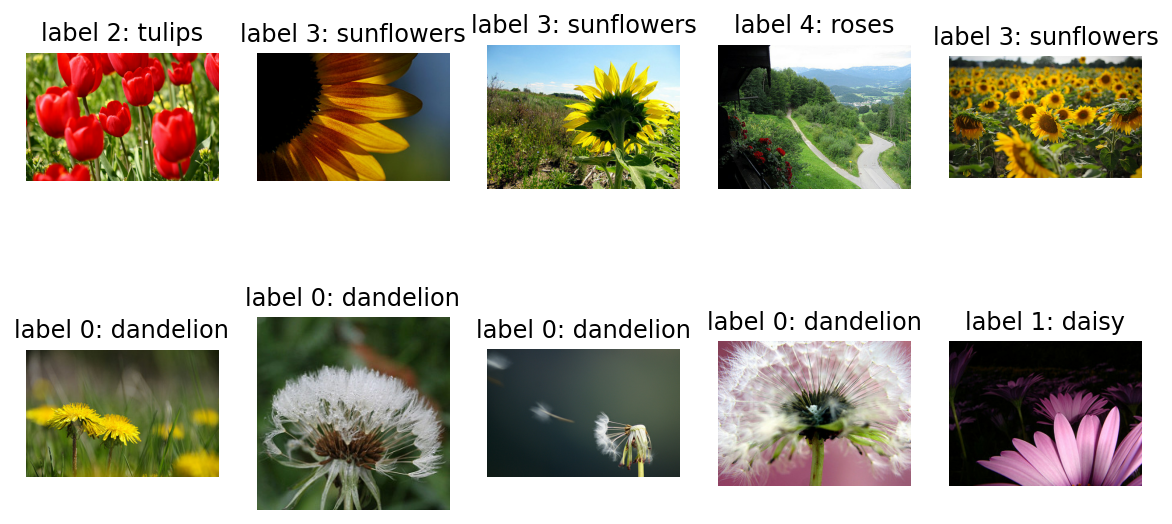

In [8]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):  # 10개의 데이터를 가져 옵니다.
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [9]:
IMG_SIZE = 160 # 리사이징할 이미지의 크기

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의 텐서플로우 버전입니다.
    image = (image/127.5) - 1 # 픽셀값의 scale 수정
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [10]:
# format_example() 함수를 raw_train, raw_validation, raw_test 에 map() 함수로 적용시켜서 원하는 모양의 train, validataion, test 데이터셋으로 변환
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>


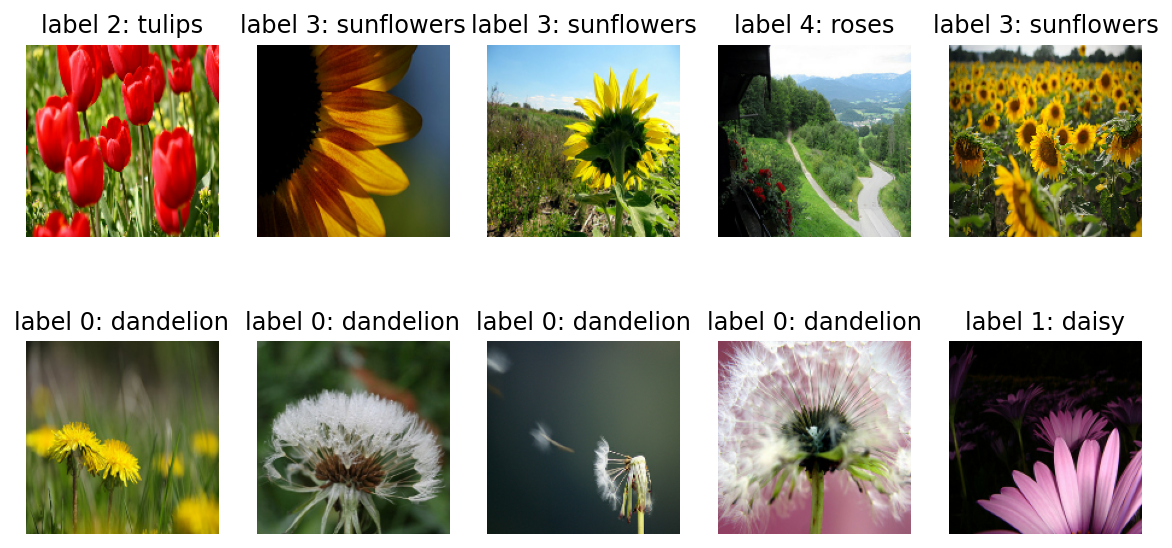

In [11]:
# 다시 이미지를 시각적으로 확인
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [12]:
# 사전 학습 모델인 VGG16을 가져오고, 모델의 구조 확인
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [13]:
# 한 스텝에 학습시킬 데이터의 개수인 BATCH_SIZE와 학습 데이터를 적절히 섞어줄 SHUFFLE_BUFFER_SIZE를 설정
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 200

In [14]:
# BATCH_SIZE에 따라 16개의 데이터를 랜덤으로 뿌려줄 train_batches, validation_batches, test_batches를 생성
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [15]:
for image_batch, label_batch in train_batches.take(1):
    break

image_batch.shape, label_batch.shape

(TensorShape([16, 160, 160, 3]), TensorShape([16]))

모델에 이 배치를 넣으면 `shape`이 어떻게 바뀔지 확인

In [16]:
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([16, 5, 5, 512])

In [17]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [18]:
# 그러면 바로 Global Average Pooling 계층을 만드는 코드를 확인
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 512)


In [19]:
# dense layer에는 unit과 activation 2개의 매개변수만 사용해주세요.
# unit의 값은 위에서 global_average_layer를 통과했을 때의 값을 생각해보세요.
# 활성화 함수는 ReLU를 사용합니다.
dense_layer = tf.keras.layers.Dense(512, activation='relu')
# unit은 우리가 분류하고 싶은 class를 생각해보세요.
# 활성화 함수는 Softmax를 사용합니다.
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

# feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)

(16, 5)


In [20]:
# VGG16에 해당하는 base_model은 학습을 시키지 않을 예정이니 학습 여부를 결정하는 trainable 변수를 False로 지정해 비활성화
base_model.trainable = False

In [21]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


In [23]:
# VGG16을 기반으로 구성된 이미지 분류기를 학습
# 모델 compile 완료 후 학습
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [24]:
EPOCHS = 20   
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/20
184/184 [==============================] - 14s 63ms/step - loss: 1.2999 - accuracy: 0.5450 - val_loss: 1.0428 - val_accuracy: 0.6730
Epoch 2/20
184/184 [==============================] - 8s 41ms/step - loss: 0.9103 - accuracy: 0.7245 - val_loss: 0.8034 - val_accuracy: 0.7248
Epoch 3/20
184/184 [==============================] - 8s 42ms/step - loss: 0.7474 - accuracy: 0.7633 - val_loss: 0.6978 - val_accuracy: 0.7548
Epoch 4/20
184/184 [==============================] - 8s 42ms/step - loss: 0.6631 - accuracy: 0.7841 - val_loss: 0.6351 - val_accuracy: 0.7657
Epoch 5/20
184/184 [==============================] - 8s 42ms/step - loss: 0.6030 - accuracy: 0.8113 - val_loss: 0.6057 - val_accuracy: 0.7793
Epoch 6/20
184/184 [==============================] - 8s 43ms/step - loss: 0.5613 - accuracy: 0.8236 - val_loss: 0.5760 - val_accuracy: 0.7984
Epoch 7/20
184/184 [==============================] - 8s 42ms/step - loss: 0.5309 - accuracy: 0.8314 - val_loss: 0.5573 - val_accuracy: 0.795

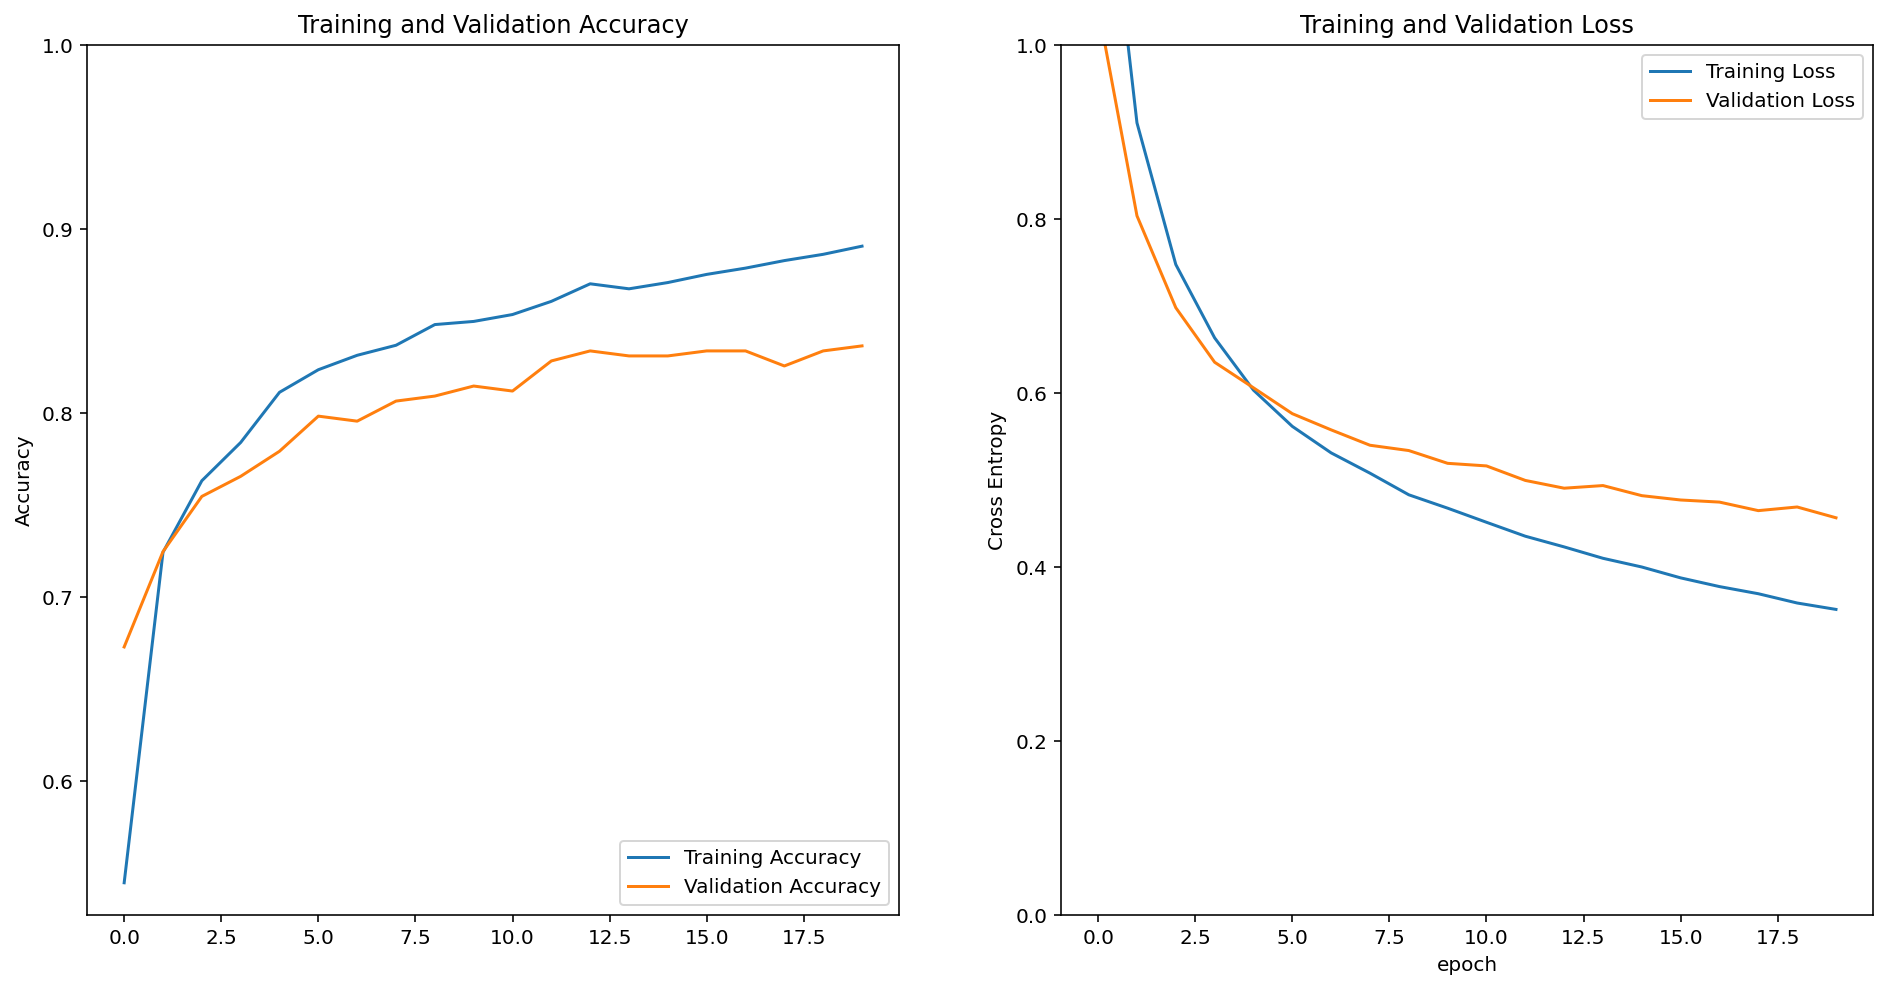

In [25]:
# 그래프로 확인
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
# 샘플을 test_batches에서 가져와서 예측 결과를 확인
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[1.46926679e-02, 3.73537801e-02, 8.02529931e-01, 1.26102017e-02,
        1.32813424e-01],
       [9.99814212e-01, 1.70502826e-04, 4.72593626e-07, 2.15628688e-06,
        1.26398527e-05],
       [7.53759205e-01, 1.19455494e-01, 1.12990690e-02, 1.00991167e-01,
        1.44950487e-02],
       [6.24355045e-04, 2.89694197e-03, 5.25739431e-01, 1.65203656e-03,
        4.69087243e-01],
       [7.51435339e-01, 2.22665593e-01, 5.19302161e-03, 7.65269389e-03,
        1.30533874e-02],
       [9.57817733e-01, 3.13130282e-02, 1.36120676e-03, 9.06559918e-03,
        4.42487624e-04],
       [4.59326757e-03, 4.93666716e-03, 9.35207129e-01, 2.89595965e-02,
        2.63033845e-02],
       [4.37641293e-01, 5.26529193e-01, 1.63811143e-04, 3.47530134e-02,
        9.12679359e-04],
       [3.73495114e-03, 3.77350341e-04, 1.34290559e-02, 9.39433753e-01,
        4.30247672e-02],
       [9.99703825e-01, 2.87950505e-04, 1.88979911e-07, 6.74214971e-06,
        1.30798423e-06],
       [9.80759978e-01, 1.7397

In [27]:
# 이번에도 prediction 값들을 실제 추론한 라벨로 변환
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 2, 0, 0, 2, 1, 3, 0, 0, 0, 3, 4, 0, 3])

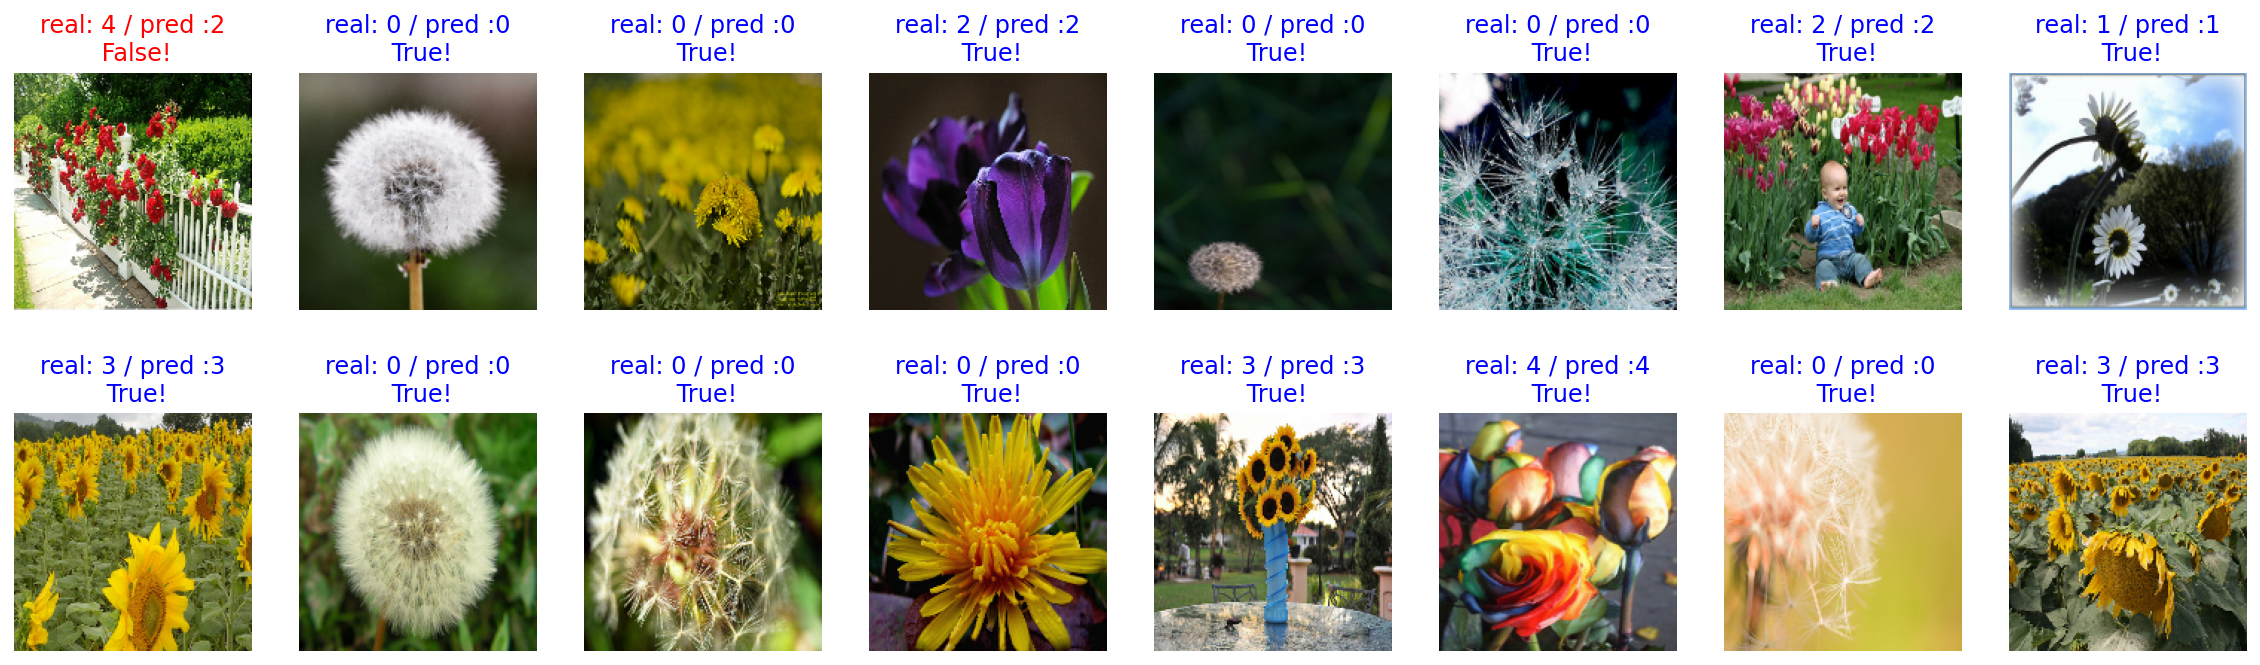

In [28]:
# 이미지로 확인
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [29]:
# 16개에 대한 정확도 확인
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 16 * 100) # 약 95% 내외

93.75


In [30]:
# 모델 save
# !mkdir -p ~/aiffel/flowers/checkpoint
# !mkdir -p ~/aiffel/flowers/images

In [31]:
import os

checkpoint_dir = os.getenv("HOME") + "/aiffel/flowers/checkpoint"
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

if not os.path.exists('checkpoint_dir'):
    os.mkdir('checkpoint_dir')
    
model.save_weights(checkpoint_file_path)     # checkpoint 파일 생성

if os.path.exists(checkpoint_file_path):
  print('checkpoint 파일 생성 OK!!')

checkpoint 파일 생성 OK!!


In [32]:
# 준비된 이미지 연결
!ln -s ~/aiffel/flowers/images/

ln: failed to create symbolic link './images': File exists


In [33]:
# tensorflow 모델에 입력해주기 위해 load_img, img_to_array 함수 불러오기
from tensorflow.keras.preprocessing.image import load_img, img_to_array

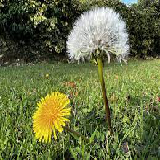

In [34]:
IMG_SIZE = 160
img_dir_path = os.getenv("HOME") + "/aiffel/flowers/images"
dandelion_image_path = os.path.join(img_dir_path, '0_dandelion.jpg')

dandelion_image = load_img(dandelion_image_path, target_size=(IMG_SIZE, IMG_SIZE))
dandelion_image

In [35]:
# 모델에 넣을 수 있도록 이미지를 array, 즉 배열 자료형으로 변환
dandelion_image = img_to_array(dandelion_image).reshape(1, IMG_SIZE, IMG_SIZE, 3)
dandelion_image.shape

(1, 160, 160, 3)

In [36]:
# 이미지를 모델에 넣어 예측
prediction = model.predict(dandelion_image)
prediction

array([[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.2658331e-20,
        0.0000000e+00]], dtype=float32)

In [37]:
predictions = np.argmax(predictions, axis=0)
predictions

13

In [38]:
# 위의 과정을 함수로 만들어 원하는 이미지를 자유자재로 예측
def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = model.predict(image)[0]
    dandelion_percentage = round(prediction[0] * 100)
    daisy_percentage = round(prediction[1] * 100)
    tulips_percentage = round(prediction[2] * 100)
    sunflowers_percentage = round(prediction[3] * 100)
    rose_percentage = round(prediction[4] * 100)
    print(f"This image seems {dandelion_percentage}% dandelion, and {daisy_percentage}% daisy, {tulips_percentage}% tulips, {sunflowers_percentage}% sunflowers, {rose_percentage}% rose.")

This image seems 100% dandelion, and 0% daisy, 0% tulips, 0% sunflowers, 0% rose.


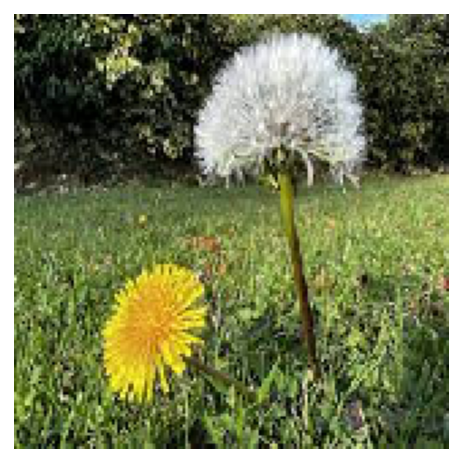

In [39]:
filename = '0_dandelion.jpg'

show_and_predict_image(img_dir_path, filename)

This image seems 0% dandelion, and 100% daisy, 0% tulips, 0% sunflowers, 0% rose.


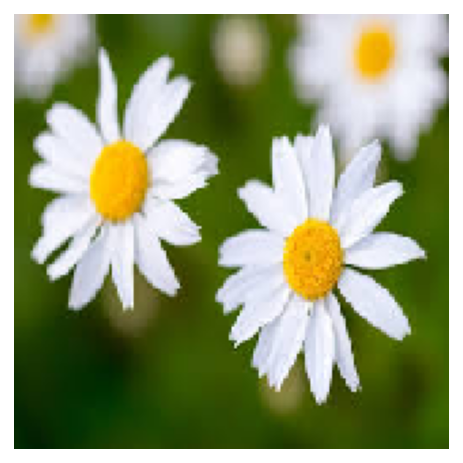

In [40]:
filename = '1_daisy.jpg'

show_and_predict_image(img_dir_path, filename)

This image seems 0% dandelion, and 0% daisy, 100% tulips, 0% sunflowers, 0% rose.


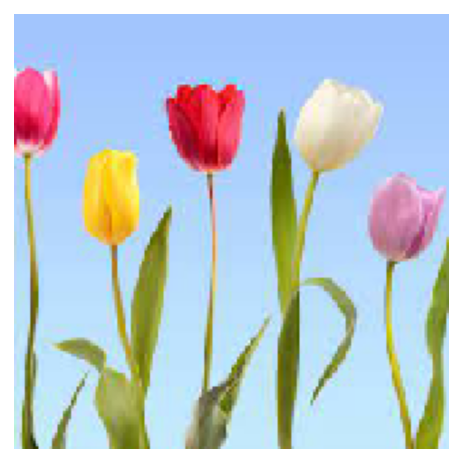

In [41]:
filename = '2_tulips.jpg'

show_and_predict_image(img_dir_path, filename)

This image seems 0% dandelion, and 0% daisy, 0% tulips, 100% sunflowers, 0% rose.


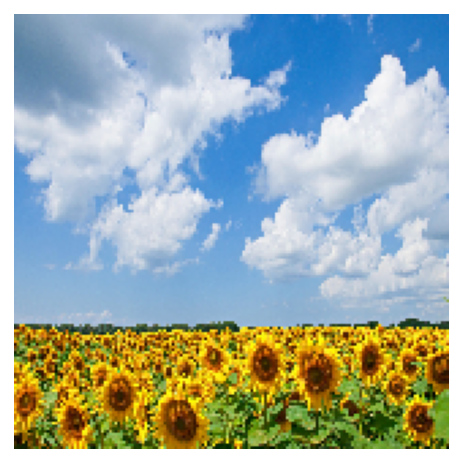

In [42]:
filename = '3_sunflowers.jpg'

show_and_predict_image(img_dir_path, filename)

This image seems 0% dandelion, and 0% daisy, 0% tulips, 0% sunflowers, 100% rose.


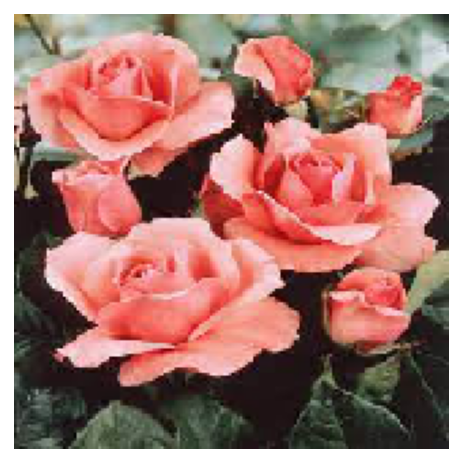

In [43]:
filename = '4_rose.jpg'

show_and_predict_image(img_dir_path, filename)

In [45]:
test_steps = 30
loss0, accuracy0 = model.evaluate(test_batches, steps=test_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

23/30 [======================>.......] - ETA: 0s - loss: 0.4217 - accuracy: 0.8447WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 30 batches). You may need to use the repeat() function when building your dataset.


30/30 [==============================] - 1s 29ms/step - loss: 0.4217 - accuracy: 0.8447
initial loss: 0.42
initial accuracy: 0.84
